In [1]:
import os
import time
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

print("Tensorflow version", tf.__version__)

Tensorflow version 1.7.0


In [2]:
# Open the file as readonly
#h5f = h5py.File('patient_data.h5', 'r')
h5f = h5py.File('patient_2Deravitive.h5', 'r')
#h5f = h5py.File('patient_data_7class.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]



# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)
print('Validation set', X_val.shape, y_val.shape)

Training set (59, 140, 140, 389) (59, 3)
Test set (17, 140, 140, 389) (17, 3)
Validation set (7, 140, 140, 389) (7, 3)


In [3]:
#Normalization
import cv2 as cv
X_train = cv.normalize(X_train,  X_train, -1, 1, cv.NORM_MINMAX)
X_test = cv.normalize(X_test,  X_test, -1, 1, cv.NORM_MINMAX)
X_val = cv.normalize(X_val,  X_val, -1, 1, cv.NORM_MINMAX)

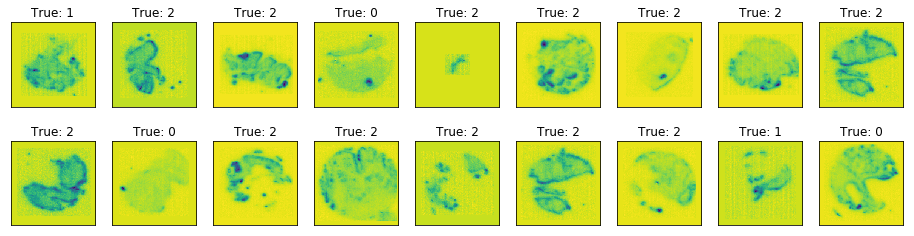

In [4]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0])
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])
        
        
# Plot 2 rows with 9 images each from the training set
plot_images(X_train, 2, 9, y_train);


In [5]:

img_size = X_train.shape[1]


num_channels = X_train.shape[-1]


num_classes = y_train.shape[1]
print(X_train.shape,img_size,num_channels,num_classes)

(59, 140, 140, 389) 140 389 3


In [6]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

In [7]:
def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):
    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new filters with the given shape
    weights = conv_weight_variable(layer_name, shape=shape)
    
    # Create new biases, one for each filter
    biases = bias_variable(shape=[num_filters])

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights

In [8]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

In [9]:
def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

In [10]:
# Convolutional Layer 1.
filter_size1 = 3         # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

In [11]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels))

In [12]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes])

y_true_cls = tf.argmax(y_true, axis=1)

In [13]:
keep_prob = tf.placeholder(tf.float32)

In [14]:
def train_model():
    conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1",
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=True)
    print(conv_1)
    
    # Apply dropout after the pooling operation
    dropout = tf.nn.dropout(conv_1, keep_prob)
    print(dropout)
    
    #flatten layer
    layer_flat, num_features = flatten_layer(dropout)
    print(layer_flat)
    
    #Fully Connected layer
    fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1",
                num_inputs=num_features,
                num_outputs=num_classes,
                relu=False)

    print(fc_1)
    
    y_pred = tf.nn.softmax(fc_1)

    # The class-number is the index of the largest element.
    y_pred_cls = tf.argmax(y_pred, dimension=1)
    
    return fc_1,y_pred_cls
    
    

In [15]:
fc_1,y_pred_cls= train_model()

# Calcualte the cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_1, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:
Use the retry module or similar alternatives.
Tensor("MaxPool:0", shape=(?, 70, 70, 16), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 70, 70, 16), dtype=float32)
Tensor("Reshape:0", shape=(?, 78400), dtype=float32)
Tensor("add_1:0", shape=(?, 3), dtype=float32)
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [16]:
# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

In [17]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
session = tf.Session()

In [19]:
session.run(tf.global_variables_initializer())
init = tf.global_variables_initializer()

In [20]:
# Number of training samples in each iteration 
batch_size = 8

# Keep probability in dropout layer
dropout = 0.25

In [25]:
total_iterations = 0
def run_train(session, train_x, train_y,num_iterations, display_step):
    print("\nStart training")
    # Start-time used for printing time-usage below.
    start_time = time.time()
    session.run(init)
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    for epoch in range(num_iterations):
        total_batch = int(train_x.shape[0] / batch_size)
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_y = train_y[i*batch_size:(i+1)*batch_size]
            feed_dict_train = {x: batch_x, y_true: batch_y, keep_prob: dropout}
            _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)
            if epoch % display_step == 0:
                print("Epoch #%d step=%d cost=%f" % (epoch, i, c))
    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_diff = time.time() - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
    


In [26]:
from sklearn.model_selection import KFold
def cross_validate(session, split_size,num_iterations, display_step):
    results = []
    kf = KFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(X_train, y_train):
        train_x = X_train[train_idx]
        train_y = y_train[train_idx]
        val_x = X_train[val_idx]
        val_y = y_train[val_idx]
        run_train(session, train_x, train_y,num_iterations, display_step)
        results.append(session.run(accuracy, feed_dict={x: val_x, y_true: val_y, keep_prob: 1.0}))
        return results
    
def optimize(num_iterations, display_step):
    with tf.Session() as session:
        result = cross_validate(session,5,num_iterations, display_step)
        print("Cross-validation result: %s" % result)
        print("Test accuracy: %f" % session.run(accuracy, feed_dict={x: X_test, y_true: y_test, keep_prob: 1.0}))


In [27]:
optimize(num_iterations=50, display_step=10)


Start training
Epoch #0 step=0 cost=1.031084
Epoch #0 step=1 cost=873.260742
Epoch #0 step=2 cost=1.085203
Epoch #0 step=3 cost=1.066373
Epoch #0 step=4 cost=0.611774
Epoch #10 step=0 cost=0.726549
Epoch #10 step=1 cost=0.929961
Epoch #10 step=2 cost=0.814708
Epoch #10 step=3 cost=0.823628
Epoch #10 step=4 cost=0.704764
Epoch #20 step=0 cost=0.630348
Epoch #20 step=1 cost=0.913835
Epoch #20 step=2 cost=0.753380
Epoch #20 step=3 cost=0.770472
Epoch #20 step=4 cost=0.608299
Epoch #30 step=0 cost=0.588293
Epoch #30 step=1 cost=0.916160
Epoch #30 step=2 cost=0.727532
Epoch #30 step=3 cost=0.751452
Epoch #30 step=4 cost=0.561923
Epoch #40 step=0 cost=0.566486
Epoch #40 step=1 cost=0.922047
Epoch #40 step=2 cost=0.713812
Epoch #40 step=3 cost=0.743807
Epoch #40 step=4 cost=0.535120
Time usage: 0:28:47
Cross-validation result: [1.0]
Test accuracy: 0.823529


In [28]:
optimize(num_iterations=200, display_step=20)


Start training
Epoch #0 step=0 cost=1.519543
Epoch #0 step=1 cost=478.896820
Epoch #0 step=2 cost=477.660400
Epoch #0 step=3 cost=1.069333
Epoch #0 step=4 cost=1.043833
Epoch #20 step=0 cost=0.643116
Epoch #20 step=1 cost=0.910716
Epoch #20 step=2 cost=0.749707
Epoch #20 step=3 cost=0.775266
Epoch #20 step=4 cost=0.612457
Epoch #40 step=0 cost=0.575414
Epoch #40 step=1 cost=0.917903
Epoch #40 step=2 cost=0.709020
Epoch #40 step=3 cost=0.746198
Epoch #40 step=4 cost=0.536763
Epoch #60 step=0 cost=0.553097
Epoch #60 step=1 cost=0.929869
Epoch #60 step=2 cost=0.695283
Epoch #60 step=3 cost=0.741232
Epoch #60 step=4 cost=0.506566
Epoch #80 step=0 cost=0.544403
Epoch #80 step=1 cost=0.938697
Epoch #80 step=2 cost=0.688378
Epoch #80 step=3 cost=0.741345
Epoch #80 step=4 cost=0.491167
Epoch #100 step=0 cost=0.540954
Epoch #100 step=1 cost=0.944636
Epoch #100 step=2 cost=0.683964
Epoch #100 step=3 cost=0.742601
Epoch #100 step=4 cost=0.482183
Epoch #120 step=0 cost=0.539782
Epoch #120 step=1 

In [ ]:
optimize(num_iterations=20000, display_step=200)

In [29]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, {x: X_test, y_true: y_test, keep_prob: 1.0})


In [30]:
test_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

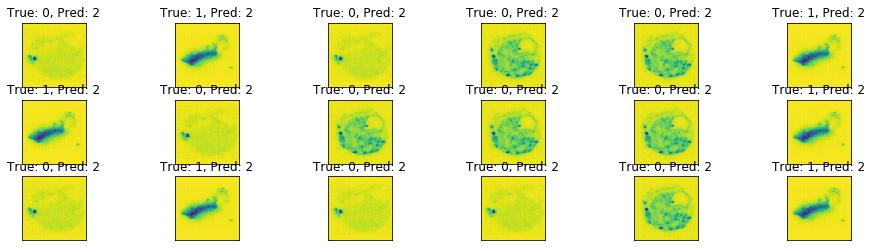

In [31]:
# Find the incorrectly classified examples
incorrect = test_pred != np.argmax(y_test, axis=1)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);


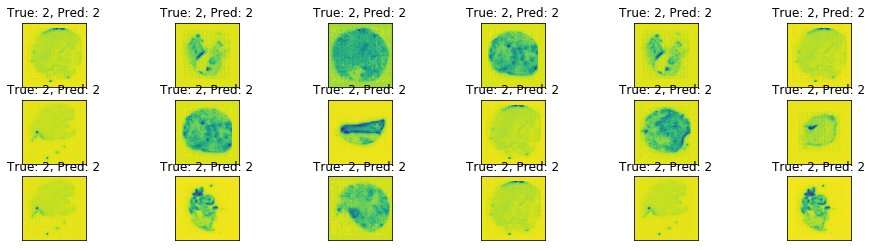

In [32]:
# Find the correctly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

In [1]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_pred)

print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);


NameError: name 'plt' is not defined

In [ ]:

os.remove(h5f)